# Нахождение закономерности в успешности игр

Описание проекта. 

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Изучение данных из файла

Импортируем библиотеки.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import norm
pd.set_option('display.max_columns', None)

Прочитаем файл и сохраним в переменной.

In [2]:
df = pd.read_csv('/datasets/games.csv')

In [3]:
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


В датасесте есть следующие столбцы:

* `Name` — название игры
* `Platform` — платформа
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score` — оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Выводы:

1. В данных есть пропуски.
2. Названия столбцов надо привести к нижнему регистру.
3. Столбец с годом надо привести к целочисленному формату.

## Предобработка данных

Для начала проверим есть ли в данных дубликаты.

In [4]:
df.duplicated().sum()

0

Явных дубликатов нет.

Приведём названия столбцов к нижнему регистру.

In [5]:
df.columns = [x.lower() for x in df.columns]

Посмотрим в каких столбцах есть пропуски и сколько их.

In [6]:
df.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Посмотрим на пропуски в name и genre.

In [7]:
df.sort_values(by='genre').tail(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Пропуски одновременно и в названии и в жанре, заполнить пропуски тут не получится, оставим как есть. Так же пропуски в critic_score, user_score и rating заполнить не получится. Пропусков в этих столбцах много, а заполнение их медианными или средними значениями может помешать в дальнейшем анализе.

Проверим столбцы на аномальные значения, для этого выведем список уникальных значений.

In [9]:
[x.unique() for x in (df['platform'], df['year_of_release'], df['genre'], df['critic_score'], df['user_score'], df['rating'])]

[array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
        'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
        'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
        '3DO', 'GG', 'PCFX'], dtype=object),
 array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
        2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
        1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
        2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
        1980., 1983.]),
 array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
        'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
        'Strategy', nan], dtype=object),
 array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
        83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
        71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
        75., 60., 63., 69., 

Согласно рейтингу организации ESRB, рейтинг 'K-A' в 1998 году был переименован в 'E'. Исправим этот момент в данных.

In [10]:
df['rating'] = df['rating'].replace('K-A', 'E')

В столбце critic_score можно заметить значение "tbd" ("to be determined", "to be defined"), оно означает, что у игры ещё нет рейтинга.

Заменим эти значения на NaN и приведём данные к числовому типу.

In [11]:
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

Для удобства столбец critic_score к такому же формату как и столбец user_score.

In [12]:
df['critic_score'] = df['critic_score'] / 10

Посчитаем суммарные продажи во всех регионах и запишем их в total_sales.

In [13]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

Посмотрим на итог предобработки данных.

In [14]:
df.info()
display(df.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             9949 non-null object
total_sales        16715 non-null float64
dtypes: float64(8), object(4)
memory usage: 1.5+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
2462,Skate 2,PS3,2009.0,Sports,0.46,0.25,0.01,0.12,8.4,7.8,T,0.84
11900,Exhibition Volume 4,XB,2003.0,Misc,0.05,0.02,0.00,0.00,NaN,NaN,NaN,0.07
12926,Defendin' De Penguin,Wii,2008.0,Strategy,0.05,0.00,0.00,0.00,NaN,NaN,NaN,0.05
14140,The Legend of Heroes: Trails in the Sky SC Evo...,PSV,2015.0,Role-Playing,0.00,0.00,0.03,0.00,NaN,NaN,NaN,0.03
9077,Marvel vs. Capcom 2: New Age of Heroes,DC,2000.0,Fighting,0.00,0.00,0.14,0.00,NaN,NaN,NaN,0.14


## Исследовательский анализ данных

### Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

Составим сводную таблицу по количеству выпущенных игр по годам, построим гистограмму по количеству игр и график по продажам в каждом году.

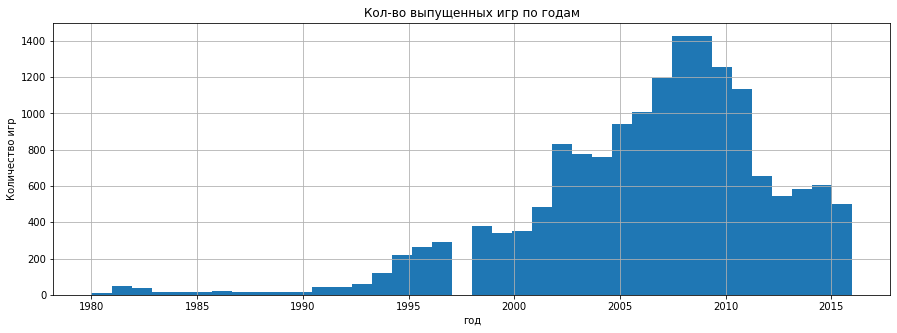

In [15]:
games_per_year = df.pivot_table(columns='year_of_release', values='name', aggfunc=['count'])

df['year_of_release'].hist(
    bins=len(df['year_of_release'].unique()), 
    figsize=(15,5)).set(xlabel='год', ylabel='Количество игр');
plt.title('Кол-во выпущенных игр по годам')
plt.show()

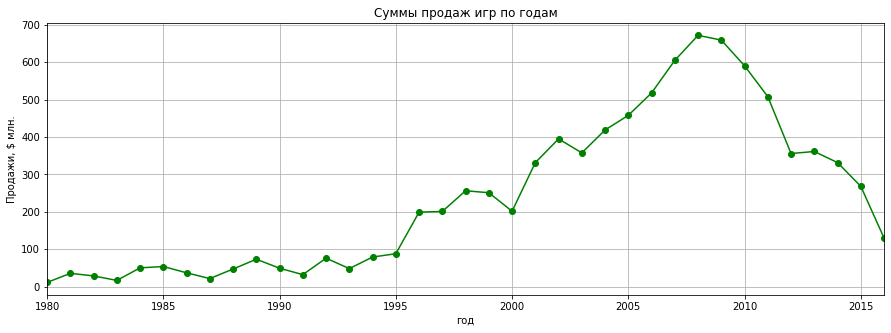

In [16]:
sales_per_year = df.pivot_table(index='year_of_release', values='total_sales', aggfunc=['sum'])

sales_per_year.plot(
    style='o-',
    figsize=(15,5), 
    c='g', 
    grid=True, 
    legend=False).set(xlabel='год', ylabel='Продажи, $ млн.');
plt.title('Суммы продаж игр по годам')
plt.show()

По двум гистограммам видно, что выпуск и продажа игр сократилась после 2009 года, это можно объяснить тем, что игроки стали более востребованны к качеству игр, да и сами игры с каждым годом становятся всё сложнее в разработке, требуя много времени и сил на создание. 

Данные за года раньше 1995 года, я считаю, можно не учитывать, так как сами игры и игровые платформы начали приобретать широкую популярность после 90х годов.

Отфильтрем таблицу, сохранив только данные за 1995 - 2016 года. Создадим ещё одну таблицу с данными за 3 последних года, для анализа продаж в дальнейшем.

In [17]:
df_filtered = df[df['year_of_release'] >= 1995]
df_3_years = df[df['year_of_release'] >= 2014]

### Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

Построим сводну таблицу продаж каждой платформы по годам.

In [18]:
sales_per_platform = df_filtered.pivot_table(
    index='platform', 
    columns='year_of_release', 
    values='total_sales', 
    aggfunc='sum')

sales_per_platform.fillna('')

year_of_release,1995.0,1996.0,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0
platform,,,,,,,,,,,,,,,,,,,,,,
3DO,0.08,,,,,,,,,,,,,,,,,,,,,
3DS,,,,,,,,,,,,,,,,,63.2,51.36,56.57,43.76,27.78,15.14
DC,,,,3.38,5.16,5.99,1.07,0.29,,,,,0.02,0.04,,,,,,,,
DS,,,,,,,,,,17.27,130.14,119.81,146.94,145.31,119.54,85.02,26.18,11.01,1.54,,,
GB,3.6,36.03,6.37,26.9,38,19.76,9.24,,,,,,,,,,,,,,,
GBA,,,,,,0.07,61.53,74.16,56.67,77.91,33.86,5.28,3.4,,,,,,,,,
GC,,,,,,,26.34,51.81,50.61,28.82,27.62,11.26,0.27,,,,,,,,,
N64,,34.1,39.5,49.24,57.87,33.97,3.25,0.08,,,,,,,,,,,,,,
NG,0.33,0.1,,,,,,,,,,,,,,,,,,,,


Определим платформы с наибольшими суммарными продажами.

In [19]:
top_10_platforms = df_filtered.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(10)
print('Топ-10 платформ с наибольшими суммарными продажами.')
print(top_10_platforms)

Топ-10 платформ с наибольшими суммарными продажами.
platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.76
PS       721.55
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
Name: total_sales, dtype: float64


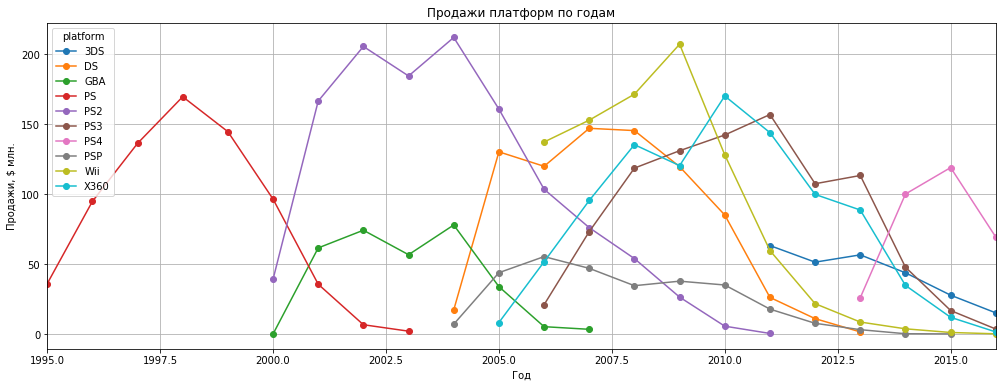

In [20]:
top_10_platforms_names = [i for i in top_10_platforms.index]

sales_top_10_platform = (df_filtered.query('platform == @top_10_platforms_names')
                           .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
                           .plot(style='o-', grid= True, legend=True, figsize=(17,6))
                           .set(xlabel='Год', ylabel='Продажи, $ млн.', title='Продажи платформ по годам'))
plt.show()

Из графика можно сделать вывод, что каждая платформа находится на рынке примерно 10 лет.

Посмотрим более точно сколько лет каждая платформа продержалась на рынке.

In [21]:
years_for_platform = (df.query('platform == @top_10_platforms_names')                        
                       .pivot_table(index=['platform','year_of_release'], values='total_sales', aggfunc='sum'))
years_for_platform.reset_index(inplace=True)
years_for_platform = years_for_platform.pivot_table(index='platform', values='year_of_release', aggfunc='count')

display(years_for_platform)
print('Mean', years_for_platform.mean())
print('Median', years_for_platform.median())

,year_of_release
platform,
3DS,6
DS,11
GBA,8
PS,10
PS2,12
PS3,11
PS4,4
PSP,12
Wii,11


Mean year_of_release    9.7
dtype: float64
Median year_of_release    11.0
dtype: float64


Теория подтвердилась, игровые платформы живут 10 лет.

### Возьмите данные за соответствующий актуальный период. Основной фактор — эти данные помогут построить прогноз на 2017 год. Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

̶Построим график продаж по каждой платформе за 10 лет, чтобы отследить какие платформы сколько живут и выделить из них актуальные.

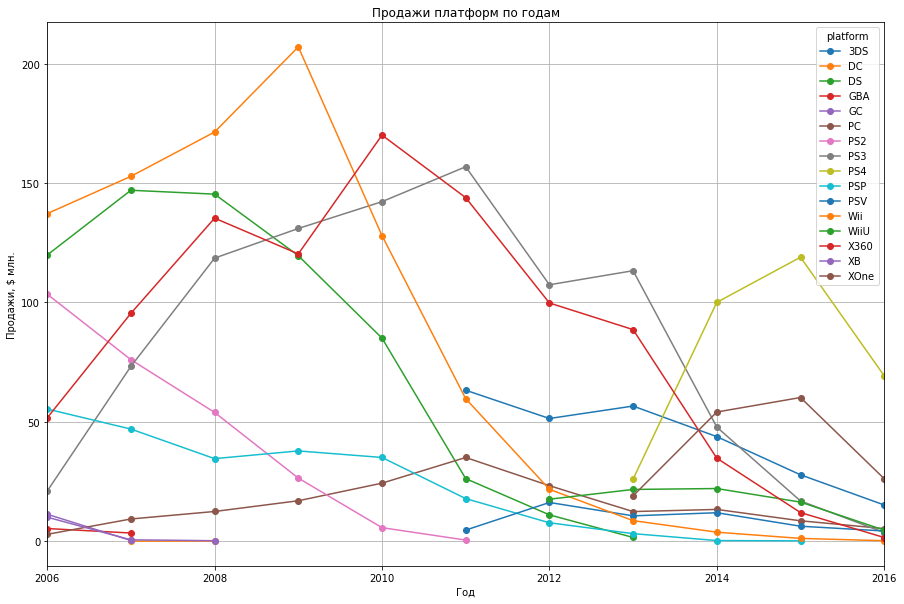

In [22]:
(df.query('year_of_release >= 2006')
   .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
   .plot(style='o-', grid= True, legend=True, figsize=(15,10))
   .set(xlabel='Год', ylabel='Продажи, $ млн.', title='Продажи платформ по годам'));
plt.show()

Данные за 2016 год не полные, поэтому создаётся ощущение, что все платформы потерпели резкий спад после 2015 года. На восходящем тренде в 2015 находятся только PS4 и XOne.

Сделаем срез по родажам за 2015 год, т. к. за 2016 данные неполные.

In [23]:
sales_in_2015 = (df.query('year_of_release == 2015')
                   .pivot_table(index='platform', values='total_sales', aggfunc='sum')
                   .sort_values(by='total_sales', ascending=False))
sales_in_2015

,total_sales
platform,
PS4,118.90
XOne,60.14
3DS,27.78
PS3,16.82
WiiU,16.35
X360,11.96
PC,8.52
PSV,6.25
Wii,1.14


Зная, что платформы живут 10 лет можно сделать вывод, что если платформа живёт уже 5-6 лет, то её можно считать неактуальной, в таком случае потенциально прибыльными будут PS4 и XOne. Исключением из правила является PC, данная платформа живёт гораздо больше 10 лет и останется актуальной в будущем.

### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

Создадим сводную таблицу по продажам каждой игры с разбивкой по платформам и посчитаем общие продажи по каждой игре.

In [24]:
actual_platform_list = [i for i in sales_in_2015[:5].index]
actual_platform_sales = (df.query('year_of_release >= 2012 and platform == @actual_platform_list')
                     .pivot_table(index='name', columns='platform', values='total_sales', aggfunc='sum'))

actual_platform_sales['game_platforms_total'] = actual_platform_sales.sum(axis=1)
actual_platform_sales.sort_values(by='game_platforms_total', ascending=False)

platform,3DS,PS3,PS4,WiiU,XOne,game_platforms_total
name,,,,,,
Grand Theft Auto V,NaN,21.05,12.62,NaN,5.47,39.14
Call of Duty: Black Ops 3,NaN,1.69,14.63,NaN,7.39,23.71
Call of Duty: Advanced Warfare,NaN,4.36,7.66,NaN,5.26,17.28
Call of Duty: Ghosts,NaN,9.36,3.83,0.35,2.92,16.46
Pokemon X/Pokemon Y,14.60,NaN,NaN,NaN,NaN,14.60
...,...,...,...,...,...,...
Crows: Burning Edge,NaN,NaN,0.01,NaN,NaN,0.01
Mario & Luigi: Paper Jam & Mario Kart 7 Double Pack,0.01,NaN,NaN,NaN,NaN,0.01
Strider (2014),NaN,0.01,NaN,NaN,NaN,0.01


Построим диаграмму размаха для продаж каждой игры.

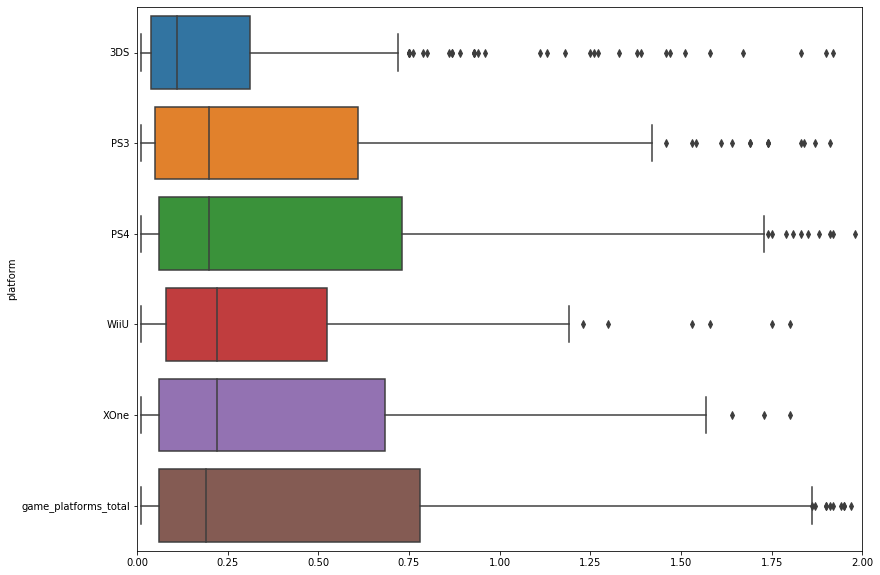

In [25]:
plt.figure(figsize=(13,10))
sns.boxplot(data=actual_platform_sales, orient='h').set_xlim(0,2);
plt.show()

<div class="alert alert-success">
<h2> Комментарий ревьюера (все отлично)</h2>
    
Здорово визуализируешь данные, молодец, что уже практикуешь методы библиотеки seaborn. 
</div>

Самые дорогие игры для платформ PS4, XOne и PS3.

Посмотрим более точно характеристики продаж.

In [26]:
actual_platform_sales.describe()

platform,3DS,PS3,PS4,WiiU,XOne,game_platforms_total
count,396.000000,492.000000,392.000000,147.000000,247.000000,1149.000000
mean,0.491439,0.586972,0.801378,0.559116,0.645020,0.904308
std,1.387161,1.464141,1.609456,1.058836,1.036139,2.299648
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,0.040000,0.050000,0.060000,0.080000,0.060000,0.060000
50%,0.110000,0.200000,0.200000,0.220000,0.220000,0.190000
75%,0.312500,0.610000,0.730000,0.525000,0.685000,0.780000
max,14.600000,21.050000,14.630000,7.090000,7.390000,39.140000


Больше всего игр продали 3DS, PS3 и PS4, игры на эти платформы также самые дорогие. Самые дешёвые игры на WiiU и XOne.

### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы. Соотнесите выводы с продажами игр на других платформах.

Исходя из прошлых пунктов, самой популярной платформой на 2015 год является PS4. Сделаем срез по этой платформе, посчитаем корреляцию между отзывами и продажами, остроим график рассеяния.

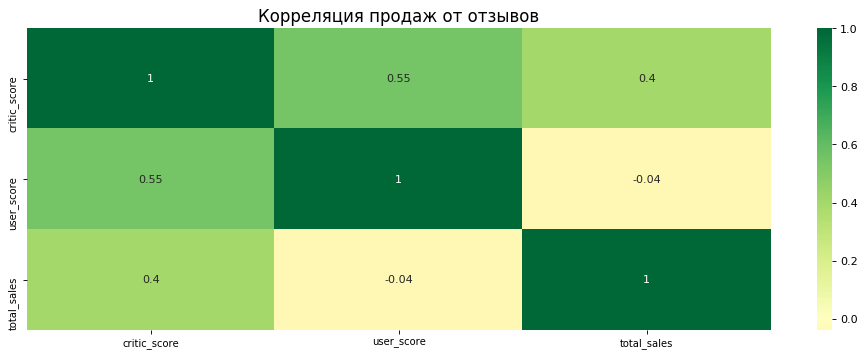

In [27]:
ps4_score_influence = (df_3_years.query('platform == "PS4" ')
                     .loc[:, ['name', 'critic_score', 'user_score', 'total_sales']])

plt.figure(figsize=(15,5), dpi= 80)
sns.heatmap(ps4_score_influence.corr(), 
            xticklabels = ps4_score_influence.corr().columns, 
            yticklabels = ps4_score_influence.corr().columns, 
            cmap='RdYlGn', 
            center=0, 
            annot=True)

plt.title('Корреляция продаж от отзывов', fontsize=15)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

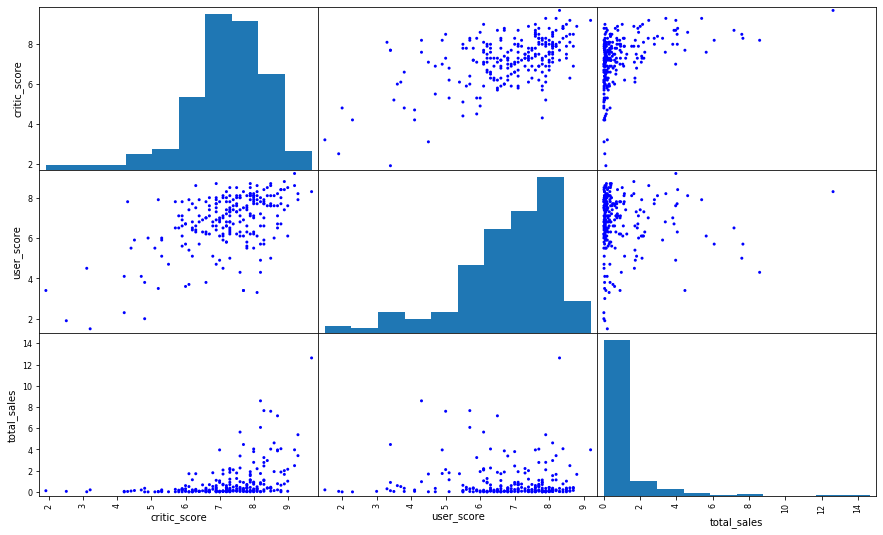

In [28]:
pd.plotting.scatter_matrix(ps4_score_influence, figsize=(15, 9), alpha=1, c='b');
plt.show()

На продажи игр влияют оценки критиков, связь умеренная, коэффициент корреляции равен 0.4. Также наблюдается взаимосвязь между оценками критиков и оценками пользователей, связь так же умеренная. Связи между продажами и оценками пользователей не выявлено. 

Если же говорить о других платформах, то ситуация скорее всего будет схожая, так как в реальной жизни люди очень часто при покупке чего-либо читают сначала отзывы, а уже после покупают продукт, и критики и обычные пользователи часто сходятся во мнениях.

### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Создадим сводную таблицу по продажам и количеству выпущенных игр по жанрам.

In [29]:
sales_per_genre = (df_3_years
                    .pivot_table(index='genre', values='total_sales', aggfunc=['sum', 'count']))

sales_per_genre.columns = ['Продажи, $ млн.', 'Количество игр, шт.']
sales_per_genre.sort_values(by='Продажи, $ млн.', inplace=True, ascending=False)
sales_per_genre.reset_index(inplace=True)
sales_per_genre

,genre,"Продажи, $ млн.","Количество игр, шт."
0,Action,199.36,619
1,Shooter,170.94,128
2,Sports,109.48,161
3,Role-Playing,101.44,221
4,Misc,37.55,113
5,Fighting,28.22,60
6,Racing,27.52,69
7,Platform,18.09,38
8,Adventure,17.55,185
9,Simulation,13.13,44


С огромной разницой в количестве игр вырывается Экшн, соответственно сумма продаж у этого жанра болльше всего. Так же к популярным жанрам можно отнести шутеры, спортивные и ролевые игры.
 
Построим график по этим данным для наглядности.

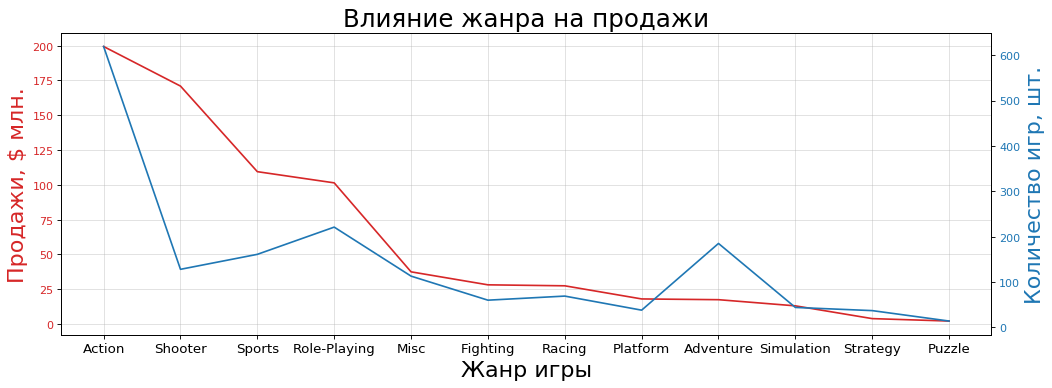

In [30]:
x = sales_per_genre['genre']
y1 = sales_per_genre['Продажи, $ млн.']
y2 = sales_per_genre['Количество игр, шт.']

fig, ax1 = plt.subplots(1,1,figsize=(15,5), dpi= 80)
ax1.plot(x, y1, color='tab:red')

ax2 = ax1.twinx()
ax2.plot(x, y2, color='tab:blue')

ax1.set_xlabel('Жанр игры', fontsize=20)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('Продажи, $ млн.', color='tab:red', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

ax2.set_ylabel('Количество игр, шт.', color='tab:blue', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_title('Влияние жанра на продажи', fontsize=22)

plt.show()

Из графика можно сделать выводы:
* Самые прибыльные жанры: Action, Shooter, Role-Playing, Sports.
* Наименее прибыльные: Simulation, Adventure, Strategy, Puzzle.

## Составление портрета пользователя каждого региона

Напишем функцию, которая выведет топ-5 платорм в заданном регионе.

In [31]:
def top_5_platforms_of_region(df, column):
    top_5_platforms = df.groupby('platform')[column].sum().sort_values(ascending=False).head()
    top_5_platforms
    (top_5_platforms.plot(autopct='%1.1f%%', 
                          kind='pie', 
                          title='Доля продаж по платформам', 
                          legend=False, figsize=(7, 7)).set(ylabel=''));
    plt.show()
    return top_5_platforms

Напишем функцию, которая выведет топ-5 жанров в заданном регионе.

In [32]:
def top_5_genres_of_region(df, column):
    top_5_genres = df.groupby('genre')[column].sum().sort_values(ascending=False).head()
    top_5_genres
    (top_5_genres.plot(autopct='%1.1f%%', kind='pie', title='Доля продаж по жанрам', legend=False, figsize=(7, 7))
                 .set(ylabel=''));
    plt.show()
    return top_5_genres

Напишем функцию, которая выведет продажи и количество проданных игр по жанрам заданного региона.

In [33]:
def influence_ESRB(df, column):
    sales_per_rating = df.pivot_table(index='rating', values=column, aggfunc=['sum', 'count'])
    sales_per_rating.columns = ['Продажи, $ млн.', 'Количество игр, шт.']
    sales_per_rating.reset_index(inplace=True)
    sales_per_rating.sort_values(by='Продажи, $ млн.', inplace=True)
    
    x = sales_per_rating['rating']
    y1 = sales_per_rating['Продажи, $ млн.']
    y2 = sales_per_rating['Количество игр, шт.']

    fig, ax1 = plt.subplots(1,1,figsize=(15,5), dpi= 80)
    ax1.plot(x, y1, color='tab:red')

    ax2 = ax1.twinx()
    ax2.plot(x, y2, color='tab:blue')

    ax1.set_xlabel('Рейтинг ESRB', fontsize=20)
    ax1.tick_params(axis='x', rotation=0, labelsize=12)
    ax1.set_ylabel('Продажи, $ млн.', color='tab:red', fontsize=20)
    ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
    ax1.grid(alpha=.4)

    ax2.set_ylabel('Количество игр, шт.', color='tab:blue', fontsize=20)
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_title('Влияние рейтинга ESRB на продажи', fontsize=22)

    plt.show()

    return sales_per_rating

### Регион North America

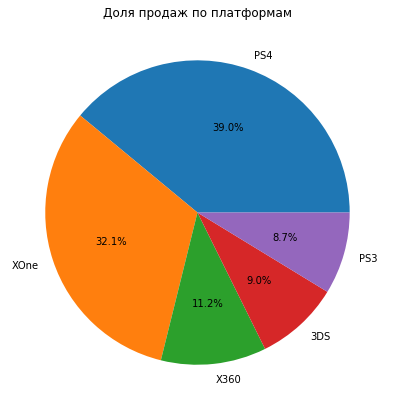

platform
PS4     98.61
XOne    81.27
X360    28.30
3DS     22.64
PS3     22.05
Name: na_sales, dtype: float64

In [34]:
na_region = (df_3_years.query('na_sales != 0 ')
             .loc[:, ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'rating']])

top_5_platforms_of_region(na_region, 'na_sales')

В Северной Америке лидерами продаж являются PS4, XOne и X360.

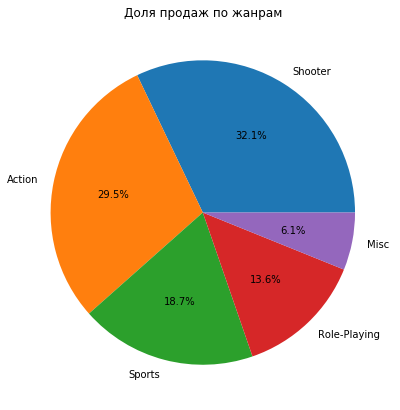

genre
Shooter         79.02
Action          72.53
Sports          46.13
Role-Playing    33.47
Misc            15.05
Name: na_sales, dtype: float64

In [35]:
top_5_genres_of_region(na_region, 'na_sales')

Самыми продаваемыми жанрами являются шутеры и экшены.

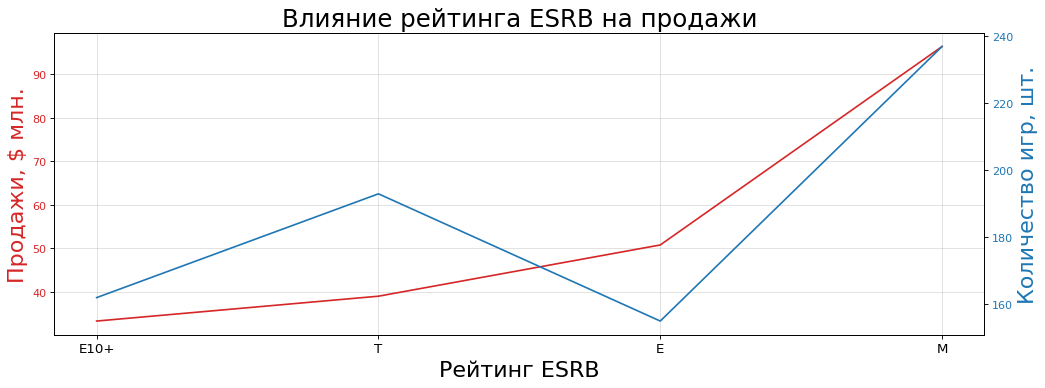

,rating,"Продажи, $ млн.","Количество игр, шт."
1,E10+,33.23,162
3,T,38.95,193
0,E,50.74,155
2,M,96.42,237


In [36]:
influence_ESRB(na_region, 'na_sales')

Максимальный по продажам рейтинг ESRB: "M" - для взрослых

### Регион Europe

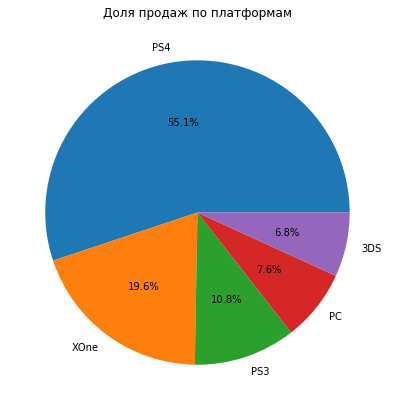

platform
PS4     130.04
XOne     46.25
PS3      25.54
PC       17.97
3DS      16.12
Name: eu_sales, dtype: float64

In [37]:
eu_region = (df_3_years.query('eu_sales != 0 ')
             .loc[:, ['name', 'platform', 'year_of_release', 'genre', 'eu_sales', 'rating']])

top_5_platforms_of_region(eu_region, 'eu_sales')

В Европе самой продаваемой платформой является PS4.

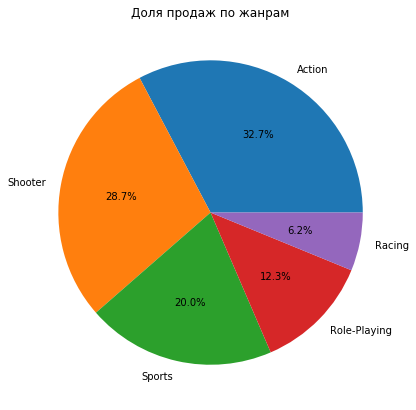

genre
Action          74.68
Shooter         65.52
Sports          45.73
Role-Playing    28.17
Racing          14.13
Name: eu_sales, dtype: float64

In [38]:
top_5_genres_of_region(eu_region, 'eu_sales')

Так же как и в Северной Америке, самыми продаваемыми жанрами являются шутеры и экшн игры.

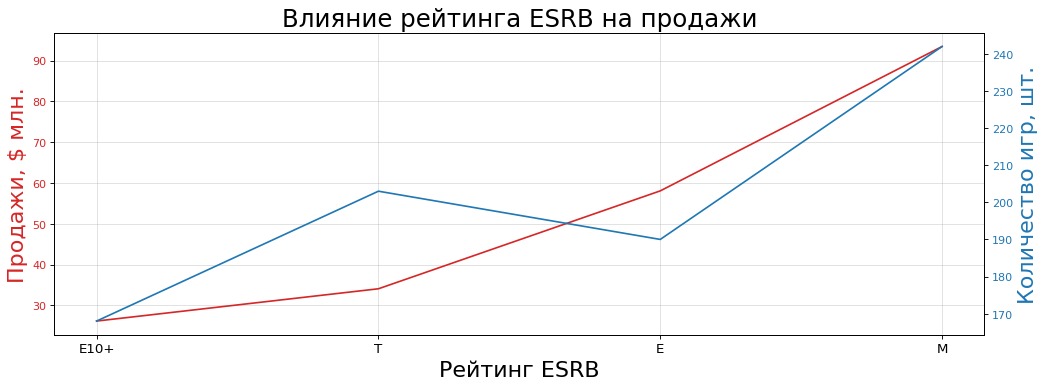

,rating,"Продажи, $ млн.","Количество игр, шт."
1,E10+,26.16,168
3,T,34.07,203
0,E,58.06,190
2,M,93.44,242


In [39]:
influence_ESRB(eu_region, 'eu_sales')

Самый продаваемый рейтинг "M" - для взрослых.

### Регион Japan

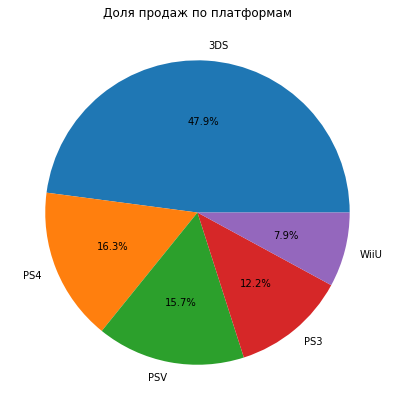

platform
3DS     44.24
PS4     15.02
PSV     14.54
PS3     11.22
WiiU     7.31
Name: jp_sales, dtype: float64

In [40]:
jp_region = (df_3_years.query('jp_sales != 0 ')
             .loc[:, ['name', 'platform', 'year_of_release', 'genre', 'jp_sales', 'rating']])

top_5_platforms_of_region(jp_region, 'jp_sales')

В Японии лидером продаж является 3DS, на втором месте PS4.

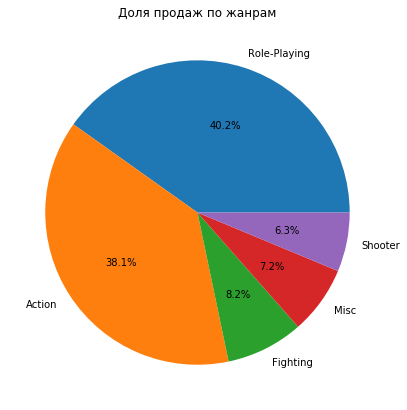

genre
Role-Playing    31.16
Action          29.58
Fighting         6.37
Misc             5.61
Shooter          4.87
Name: jp_sales, dtype: float64

In [41]:
top_5_genres_of_region(jp_region, 'jp_sales')

Самыми популярными жанрами здесь являются ролевые игры и экшены.

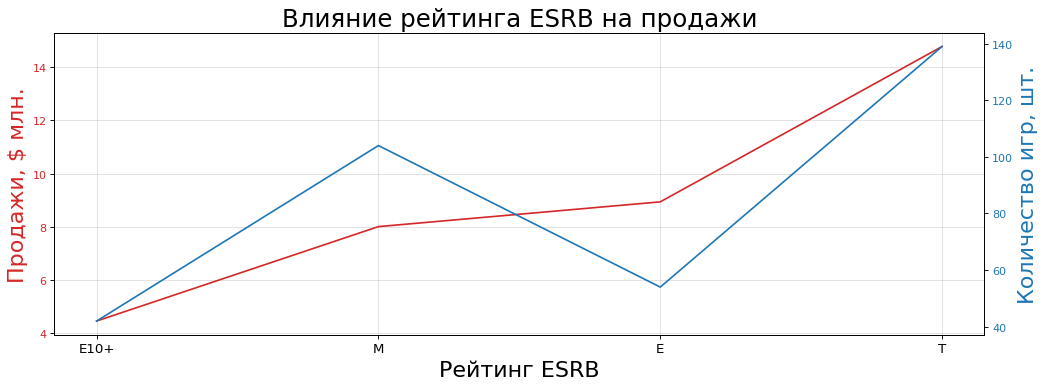

,rating,"Продажи, $ млн.","Количество игр, шт."
1,E10+,4.46,42
2,M,8.01,104
0,E,8.94,54
3,T,14.78,139


In [42]:
influence_ESRB(jp_region, 'jp_sales')

Максимальными по продажам является рейтинг "Т" - для подростков.

Выводы:

Портрет пользователя NA (North America):
* Предпочитает PS4 и XOne.
* Любит жанры Action и Shooter с рейтингом для взрослых.

Портрет пользователя EU:
* Предпочитает PS4 и XOne.
* Любит жанры Action и Shooter с рейтингом для взрослых.

Портрет пользователя JP:
* Предпочитает 3DS.
* Любит жанры Role-Playing и Action с рейтингом для подростков.

## Проверка гипотез

Гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

H₀: Средние пользовательские рейтинги платформ Xbox One и PC равны.

H₁: Средние пользовательские рейтинги платформ Xbox One и PC различается.

In [43]:
alpha = .05

xone_user_rating = df.query('year_of_release >= 2012 and platform == "XOne"')['user_score'].dropna()
pc_user_rating = df.query('year_of_release >= 2012 and platform == "PC"')['user_score'].dropna()

print('Средний пользовательский рейтинг платформы Xbox One: {:.2f}'.format(xone_user_rating.mean()))
print('Средний пользовательский рейтинг платформы PC: {:.2f}'.format(pc_user_rating.mean()))

results = st.ttest_ind(xone_user_rating, pc_user_rating, equal_var = True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средний пользовательский рейтинг платформы Xbox One: 6.52
Средний пользовательский рейтинг платформы PC: 6.43
p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


Гипотеза подтвердилась. Средние пользовательские рейтинги платформ Xbox One и PC равны.

Гипотеза: Средние пользовательские рейтинги жанров Action и Sports разные.

H₀: Средние пользовательские рейтинги жанров Action и Sports не отличаются.

H₁: Средние пользовательские рейтинги жанров Action и Sports разные.

In [44]:
alpha = .05

action_user_rating = df.query('year_of_release >= 2012 and genre == "Action"')['user_score'].dropna()
sports_user_rating = df.query('year_of_release >= 2012 and genre == "Sports"')['user_score'].dropna()

print('Средний пользовательский рейтинг жанра Action: {:.2f}'.format(action_user_rating.mean()))
print('Средний пользовательский рейтинг жанра Sport: {:.2f}'.format(sports_user_rating.mean()))
                                                                     
results = st.ttest_ind(action_user_rating, sports_user_rating, equal_var = True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средний пользовательский рейтинг жанра Action: 6.83
Средний пользовательский рейтинг жанра Sport: 5.46
p-значение: 3.7163089460934874e-26
Отвергаем нулевую гипотезу


Гипотеза подтвердилась. Средние пользовательские рейтинги жанров Action и Sports разные.

Гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. (2014-2016)

H₀: Средние пользовательские рейтинги платформ Xbox One и PC равны.

H₁: Средние пользовательские рейтинги платформ Xbox One и PC различается.

In [45]:
alpha = .05

xone_user_rating = df.query('year_of_release >= 2014 and platform == "XOne"')['user_score'].dropna()
pc_user_rating = df.query('year_of_release >= 2012 and platform == "PC"')['user_score'].dropna()

print("Проверка гипотез по данным за 2014-2016")
print('Средний пользовательский рейтинг платформы Xbox One: {:.2f}'.format(xone_user_rating.mean()))
print('Средний пользовательский рейтинг платформы PC: {:.2f}'.format(pc_user_rating.mean()))

results = st.ttest_ind(xone_user_rating, pc_user_rating, equal_var = True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Проверка гипотез по данным за 2014-2016
Средний пользовательский рейтинг платформы Xbox One: 6.59
Средний пользовательский рейтинг платформы PC: 6.43
p-значение: 0.30395192726045817
Не получилось отвергнуть нулевую гипотезу


Гипотеза подтвердилась. Средние пользовательские рейтинги платформ Xbox One и PC равны.

Гипотеза: Средние пользовательские рейтинги жанров Action и Sports разные. (2014-2016)

H₀: Средние пользовательские рейтинги жанров Action и Sports не отличаются.

H₁: Средние пользовательские рейтинги жанров Action и Sports разные.

In [46]:
alpha = .05

action_user_rating = df.query('year_of_release >= 2014 and genre == "Action"')['user_score'].dropna()
sports_user_rating = df.query('year_of_release >= 2014 and genre == "Sports"')['user_score'].dropna()

print("Проверка гипотез по данным за 2014-2016")
print('Средний пользовательский рейтинг жанра Action: {:.2f}'.format(action_user_rating.mean()))
print('Средний пользовательский рейтинг жанра Sport: {:.2f}'.format(sports_user_rating.mean()))
                                                                     
results = st.ttest_ind(action_user_rating, sports_user_rating, equal_var = True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Проверка гипотез по данным за 2014-2016
Средний пользовательский рейтинг жанра Action: 6.76
Средний пользовательский рейтинг жанра Sport: 5.23
p-значение: 2.8711147985105864e-19
Отвергаем нулевую гипотезу


Гипотеза подтвердилась. Средние пользовательские рейтинги жанров Action и Sports разные.

## Общий вывод

Исходя из анализа, можно сделать выводы:

* Актуальный период для прогноза на 2017 год - 3 года, т.е. с 2014 года.
* Из всех платформ только PS4, XOne на восходящем тренде, остальные в нисходящем тренде.
* Потенциально прибыльные платформы PS4, XOne, PC.
* По продажам лидируют PS3, PS4, WiiU, X360, XOne.
* Отзывы критиков вляиют на продажи. Отзывы пользователей не влияют на продажи.
* Самые высокие продажи в жанрах Action, Shooter, Role-Playing, Sports.

Портреты пользователей для разных регионов:

Портрет пользователя NA (North America):
* Предпочитает PS4 и XOne.
* Любит жанры Action и Shooter с рейтингом для взрослых.

Портрет пользователя EU:
* Предпочитает PS4 и XOne.
* Любит жанры Action и Shooter с рейтингом для взрослых.

Портрет пользователя JP:
* Предпочитает 3DS.
* Любит жанры Role-Playing и Action с рейтингом для подростков.

Проверка гипотез привела к следующим выводам:
* Средние пользовательские рейтинги платформ Xbox One и PC равны.
* Средние пользовательские рейтинги жанров Action и Sports разные.